In [505]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.mlab as mlab
from math import sqrt
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

%load_ext autoreload
%autoreload 2
import alphas, costs, model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
all_dengue = pd.read_csv("all-dengues.csv")

all_dengue.index = pd.DatetimeIndex(all_dengue.date)
all_dengue = all_dengue.drop(['date','date.1'],axis=1)
all_dengues = all_dengue.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])

In [31]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [32]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [543]:
def get_two_std_away(cur_predicted_weeks):
    cur_week_data = cur_predicted_weeks
    cur_week_mean = cur_week_data.mean()
    cur_week_std = cur_week_data.std()
    two_std = (cur_week_std*3)
    lower_bnd, upper_bnd = cur_week_mean - two_std, cur_week_mean + two_std
    cur_week_data_df = pd.DataFrame(cur_week_data)
    two_std_mask = (cur_week_data_df >= lower_bnd) & (cur_week_data_df <= upper_bnd)
    final_cur_week_data_df = pd.DataFrame(cur_week_data_df[two_std_mask])
    final_cur_week_data_df.columns = ['Percentage Away']
    final_cur_week_data_df = final_cur_week_data_df.dropna()
    return final_cur_week_data_df

In [168]:
def guess(w, nth_week, cases_for_prediction):

    def omega(w, cases_for_prediction):
        pad_y = np.concatenate(([1],np.array(cases_for_prediction)))
        weights = np.array(w[:-2])
        positive_weights = weights**2
        all_cases = np.dot(positive_weights,pad_y)
        return all_cases

    # there's no amplitude in the season since the omega is absorbed in the above f'n
    def season_cos_sq(w, nth_week):
        pi = np.math.pi
        coeff = pi/26.
        shift_phase = w[-1]
        inside = coeff*(nth_week - shift_phase)
        sine = np.math.sin(inside)
        c_sq = w[-2]**2
        score = 1 + c_sq + sine
        return score
    
    return omega(w,cases_for_prediction) * season_cos_sq(w,nth_week)

def get_predictions(LAG, real, ws, nweeks_to_predict=[1]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, case_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction)
        for i in range(weeks_ahead):
            week_to_predict = case_week_to_predict + i
            cur_prediction = guess(ws,i ,prev_cases)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,16
        predictions = []
        for start_week in range(len(real)-(LAG)):
            case_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:case_week_to_predict]

            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                case_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
    return all_predictions

In [385]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases[:-52],cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("product-of-autoregression-and-seasonal-part-thailand-dengue-cases-1-2-4-8-16.pdf",dpi = 300, bbox_inches='tight')
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [43]:
cm_26 = [
        5.55917311e-01,   0.00000000e+00,   0.00000000e+00,
        0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        1.43979560e-07,   2.58447817e-06,   4.35620906e-06,
        2.42314044e-06,   4.18292725e-05,   9.95280487e-02,
        1.20080838e-08,   5.85040623e-09,   9.05147152e-08,
        6.05848674e-02,   1.58094692e-01,   6.36170521e-07,
        3.98596328e-09,   2.42543285e-07,   8.65401247e-08,
        8.14743330e-08,   1.54084213e-07,   5.66295105e-01,
        1.18549297e+00,   8.91216190e+00
     ]

In [69]:
# cm_26 = alphas.get_alphas(26,cm_dengues_train)

getting alphas ...
done getting alphas ...


In [75]:
cm_26.x

# cm_26.x = [5.55917311e-01,   0.00000000e+00,   0.00000000e+00,
#          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
#          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
#          1.43979560e-07,   2.58447817e-06,   4.35620906e-06,
#          2.42314044e-06,   4.18292725e-05,   9.95280487e-02,
#          1.20080838e-08,   5.85040623e-09,   9.05147152e-08,
#          6.05848674e-02,   1.58094692e-01,   6.36170521e-07,
#          3.98596328e-09,   2.42543285e-07,   8.65401247e-08,
#          8.14743330e-08,   1.54084213e-07,   5.66295105e-01,
#          1.18549297e+00,   8.91216190e+00]

array([  5.55917311e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.43979560e-07,   2.58447817e-06,   4.35620906e-06,
         2.42314044e-06,   4.18292725e-05,   9.95280487e-02,
         1.20080838e-08,   5.85040623e-09,   9.05147152e-08,
         6.05848674e-02,   1.58094692e-01,   6.36170521e-07,
         3.98596328e-09,   2.42543285e-07,   8.65401247e-08,
         8.14743330e-08,   1.54084213e-07,   5.66295105e-01,
         1.18549297e+00,   8.91216190e+00])

In [528]:
def plot_prediction(LAG, real, ws, province, nweeks_to_predict=[1,2,4,8,16]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, first_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction)
        for i in range(weeks_ahead):
            week_to_predict = first_week_to_predict + i
            cur_prediction = model.guess(ws, week_to_predict, prev_cases)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,12
        predictions = []
        for start_week in range(len(real)-(LAG-1)):
            first_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:first_week_to_predict]
            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                first_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
    return all_predictions

    ## plot all predictions
    plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions)
        
#         title = "%s's Dengue Prediction %d lags: %d week(s) ahead [avoid negative by squaring]"%(province,LAG,nweek)
#         start_predict_week = LAG+(nweek-1)
#         make_line(start_predict_week, real, predictions, title, "# week starting 2003","cases")
#         seperate_train_test(real,cm_dengues_train)

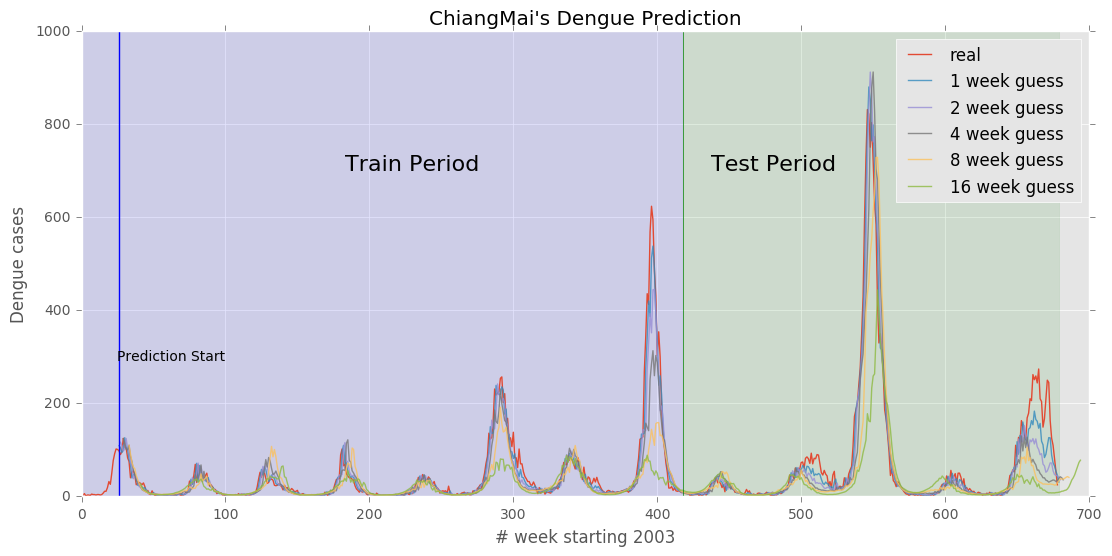

In [494]:
plot_prediction(26,cm_dengues_df.cases[:-52],cm_26.x,"ChiangMai")

In [614]:
# def get_distances(LAG, all_predictions, real):

#     def distance(prediction, real):
#         all_residual = real - prediction
#         return all_residual

#     weeks = [1]
#     ret = []
#     for idx,prediction in enumerate(all_predictions):
#         cur_pred = np.array(prediction)
#         # compare with real
#         # doesnt take into the accout of the predicted week(s)
#         cur_pred_range = cur_pred[:-weeks[idx]]
#         real_range = real[LAG+weeks[idx]:]
#         ret.append(distance(cur_pred_range,real_range))

#     return ret

def get_distances_simple(all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real)
    res = np_real - np_all_pred
    return res

def get_distances_percent(all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real)
    ret = []
    for idx,real_case in enumerate(np_real):
        if real_case >= 100:
            pred_case = np_all_pred[idx]
#             print pred_case, real_case
            score = real_case - pred_case
            percent_ = score/real_case
            ret.append(percent_)
    return np.array(ret)

In [457]:
# weeks_ahead = [1]

cur_ws = cm_26.x
cur_train = cm_dengues_train
cur_real = cm_dengues_df
cur_test = cm_dengues_test
    
predictions_to_validate = get_predictions(
        26,
        cur_test,
        cur_ws)
    
test_err = get_distances(
        26,
        predictions_to_validate,
        cur_test)


235 235
234 234
232 232
228 228
220 220


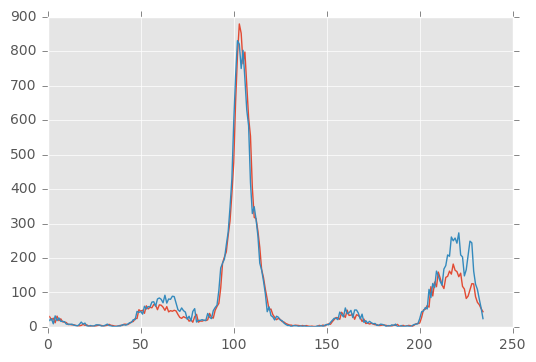

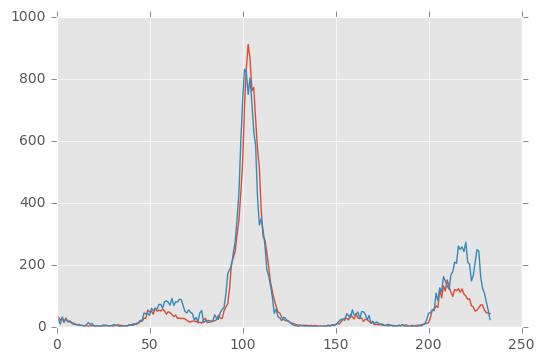

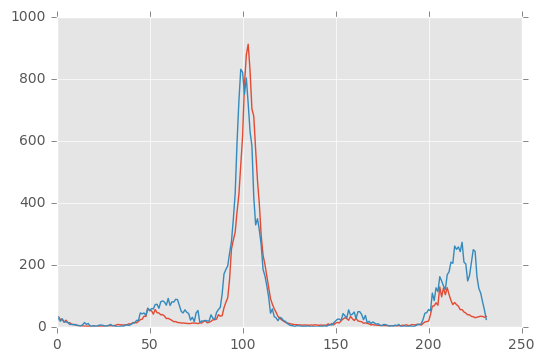

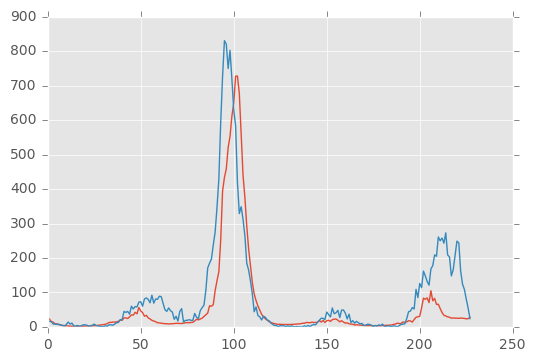

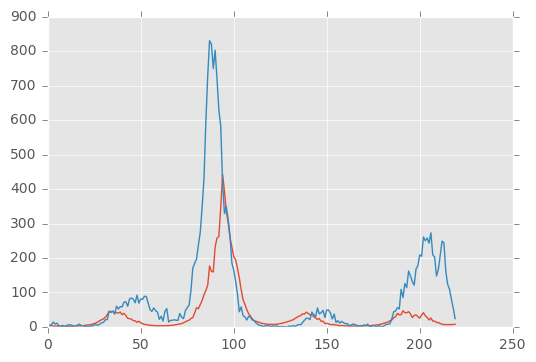

In [531]:
all_pred = plot_prediction(26,cm_dengues_df.cases[:-52],cm_26.x,"ChiangMai")
wks = [1,2,4,8,16]
percent_err = []
for i in range(5):
    wk = wks[i]
    pred_test = all_pred[i][418:-wk]
    real_test = np.array(cur_test)[27:][wk-1:-52]
    print len(pred_test), len(real_test)
    plt.plot(pred_test)
    plt.plot(real_test)
    plt.figure()
    cur_per_err = get_distances_percent(pred_test,real_test)
    percent_err.append(cur_per_err)

In [398]:
def RMSE(real, predicted):
    np_real, np_predicted = np.array(real), np.array(predicted)
    mse = mean_squared_error(np_real, np_predicted)
    score = sqrt(mse)
    return score

235 235
234 234
232 232
228 228
220 220


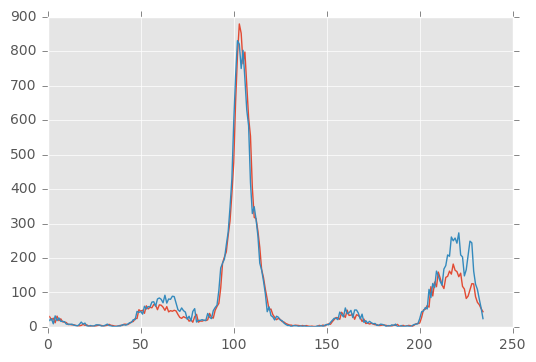

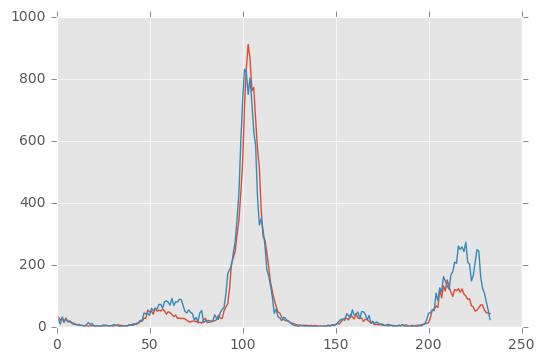

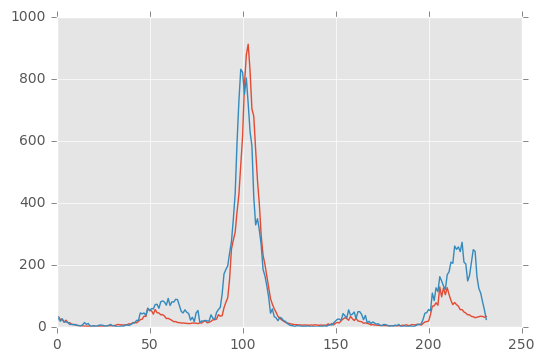

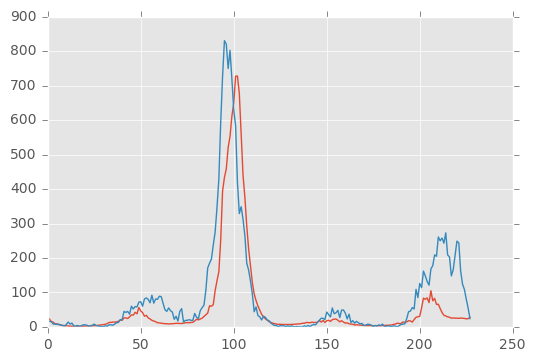

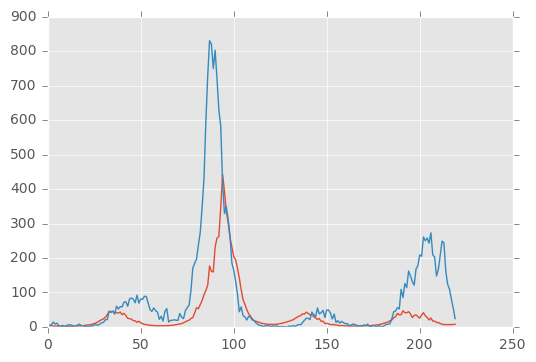

In [615]:
# all_pred = plot_prediction(26,cm_dengues_df.cases[:-52],cm_26.x,"ChiangMai")
wks = [1,2,4,8,16]
real_err = []
for i in range(5):
    wk = wks[i]
    pred_test = all_pred[i][418:-wk]
    real_test = np.array(cur_test)[27:][wk-1:-52]
    print len(pred_test), len(real_test)
    plt.plot(pred_test)
    plt.plot(real_test)
    plt.figure()
    cur_per_err = get_distances_simple(pred_test,real_test)
    real_err.append(cur_per_err)

In [616]:
real_err

[array([ -5.66382467e+00,  -1.16289514e+01,   3.58012433e+00,
         -1.62437659e+01,   2.00186609e+01,  -1.32672144e+01,
          7.95017354e+00,  -7.38990995e+00,   1.21140738e+00,
          1.27733458e+00,  -4.61583995e+00,   1.30811359e+00,
         -3.22881516e-01,   2.12279473e+00,  -1.21806457e+00,
         -1.70550202e-01,  -2.41594622e-01,   4.03478387e+00,
          9.72244470e+00,   5.39617499e-01,   6.45002413e+00,
         -2.96825871e+00,  -2.61962569e-01,   2.30762671e+00,
         -6.84949291e-01,   1.08470902e+00,   3.12805009e+00,
          1.56476763e+00,   2.42416908e-01,  -2.01245511e+00,
          7.72833437e-01,   1.69816099e+00,   3.27971394e+00,
         -3.40712019e+00,  -1.52123212e+00,  -2.88403478e+00,
         -1.26121057e+00,  -1.06714533e+00,   7.87908919e-01,
         -2.51166898e+00,   2.11789806e+00,  -1.80145147e+00,
         -2.72078118e+00,   1.38460091e+00,   2.02315743e+00,
         -1.49893013e+00,   5.34807688e+00,  -3.23340059e+00,
        

In [321]:
# train_len = 417
# # plt.plot(np.array(cur_train)[26+16:])
# wks = [1,2,4,8,16]
# for i in range(5):
#     wk = wks[i] # 1,2,4,8,16
#     real_train = np.array(cur_train)[26+wk:] # start predicting at week 27th
#     pred_train = all_predictions[i][:(train_len-(26+wk))]
#     print wk, RMSE(real_train,pred_train)

0.923344947735


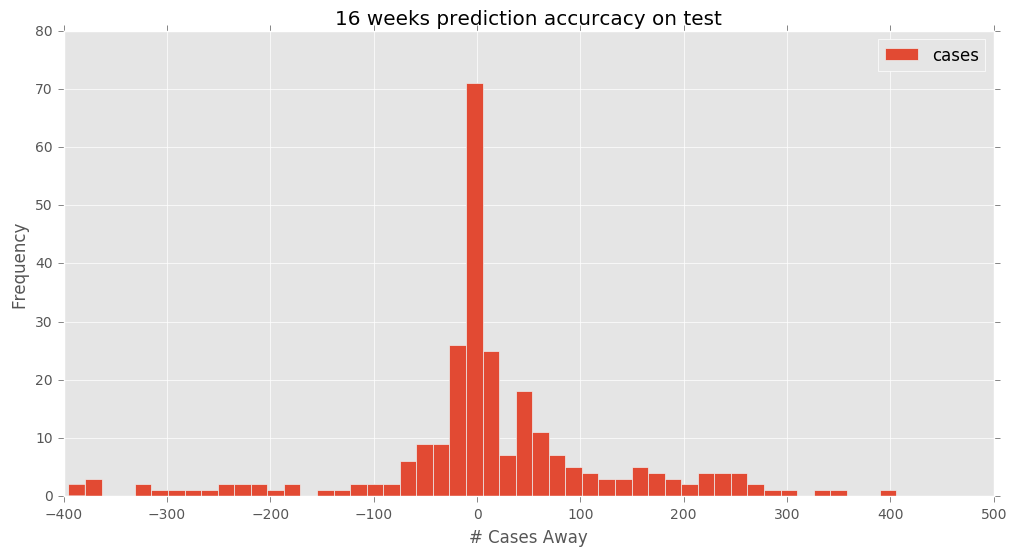

In [406]:
# weeks_predicted = [1,2,4,8,16]
# for idx, week in enumerate(weeks_predicted):
cur_distance_away_data = err[0]
two_std_away_data = get_two_std_away(cur_distance_away_data)

title = "16 weeks prediction accurcacy on test"
two_std_away_data.plot(kind="hist",bins=50,title=title,figsize=(12,6))
plt.xlabel("# Cases Away")
# plt.savefig("model-04-16-weeks-prediction-accuracy-test.pdf")
print len(two_std_away_data) / float(len(cur_distance_away_data))

two_std_away_data has size of 213
mean: 34.703623; std: 73.436539
0.968181818182


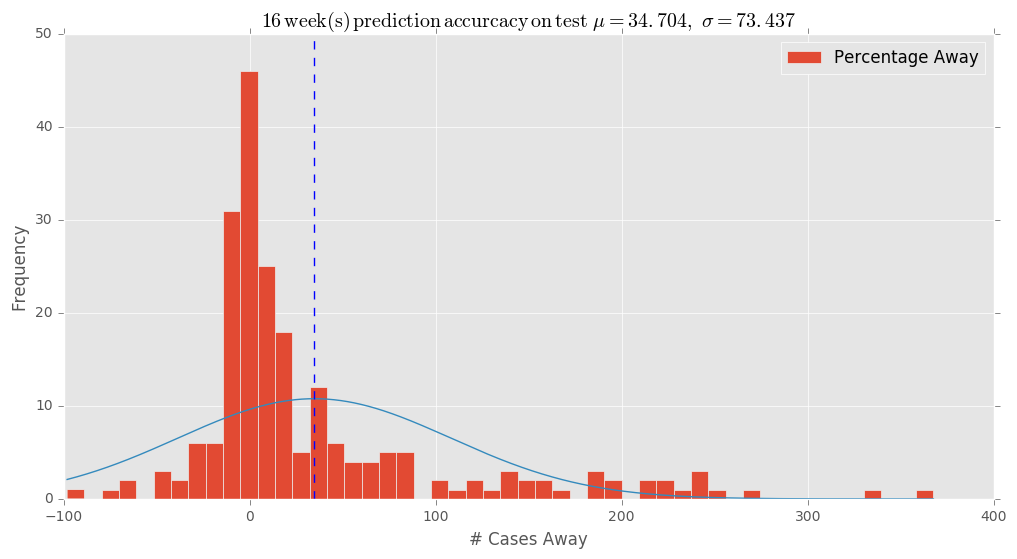

In [644]:
cur_distance_away_data = real_err[4]
two_std_away_data_plot = get_two_std_away(cur_distance_away_data)
two_std_away_data = np.array(two_std_away_data_plot)

(mu, sigma) = norm.fit(two_std_away_data)
# 
n, bins, patches = plt.hist(two_std_away_data, 50, normed=1, alpha=0.75)
plt.close()
bin_width = bins[1] - bins[0]

week_to_predict = 16
title = r'$\mathrm{%d\,week(s)\,prediction\,accurcacy\,on\,test}\ \mu=%.3f,\ \sigma=%.3f$' %(week_to_predict,mu, sigma)
two_std_away_data_plot.plot(kind="hist",bins=50,title=title,figsize=(12,6)) # hist give bin size
plt.xlabel("# Cases Away")
range_ = np.arange(two_std_away_data.min(), two_std_away_data.max(), 0.001)
plt.plot(range_, norm.pdf(range_,two_std_away_data.mean(),two_std_away_data.std())*len(two_std_away_data)*bin_width)
plt.axvline(float(two_std_away_data.mean()),ls='--')
plt.xlim(-100,400)
plt.savefig("model-02-16-weeks-prediction-accuracy-test-raw.pdf",dpi = 300, bbox_inches='tight')

print 'two_std_away_data has size of', len(two_std_away_data)
print 'mean: %f; std: %f'%(mu,sigma)
print len(two_std_away_data) / float(len(cur_distance_away_data))
# print len(two_std_away_data),len(outside_two_std),len(cur_distance_away_data)
# print outside_two_std.max(),outside_two_std.min()



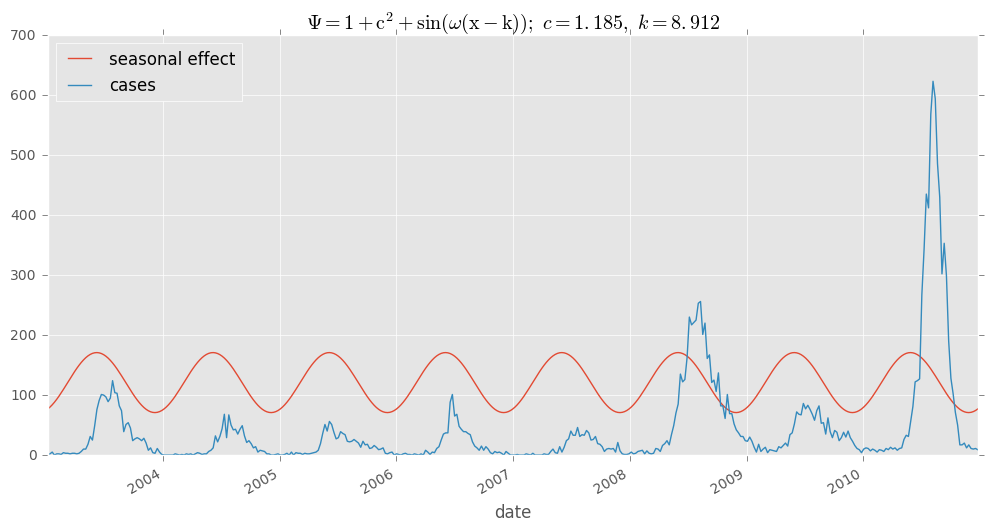

In [597]:
# seasonal

1.18549297e+00,   8.91216190e+00

# def season_cos_sq(nth_week):
#     w = [1.18549297e+00,   8.91216190e+00]
#     pi = np.math.pi
#     coeff = pi/26.
#     shift_phase = 8.91216190e+00#w[1]
#     inside = (coeff*nth_week) - (coeff*shift_phase)
#     sine = np.math.sin(inside)
#     c_sq = (1.18549297e+00)**2#w[0]**2
#     score = 1 + c_sq + sine
#     return score

# period = np.linspace(0,104)
# season_cos_sq(period)


def season(x_week):
    pi = np.math.pi
    coeff = pi/26.
    inside = (coeff*x_week) - (coeff*8.91)
    sine = np.math.sin(inside)
    return (1+(1.19)**2 + sine)*50
    

TRAIN = cm_dengues_train
ys = [season(i) for i in range(len(TRAIN))]
plt.figure(figsize=(12,6))
plt.plot(TRAIN.index,ys,label='seasonal effect')
TRAIN.plot()
plt.legend(loc='best')
title = r'$\mathrm{\Psi = 1 + c^{2} + \sin(\omega(x - k))};\ c=%.3f,\ k=%.3f$' %(1.1854, 8.9121)
plt.title(title)
plt.savefig("seasonal-effect-ChiangMai.pdf",dpi = 300, bbox_inches='tight')

array([  5.55917311e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.43979560e-07,   2.58447817e-06,   4.35620906e-06,
         2.42314044e-06,   4.18292725e-05,   9.95280487e-02,
         1.20080838e-08,   5.85040623e-09,   9.05147152e-08,
         6.05848674e-02,   1.58094692e-01,   6.36170521e-07,
         3.98596328e-09,   2.42543285e-07,   8.65401247e-08,
         8.14743330e-08,   1.54084213e-07,   5.66295105e-01,
         1.18549297e+00,   8.91216190e+00])